In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.special import softmax
from matplotlib.collections import LineCollection

In [2]:
def make_helices(n_samples=1200, noise=0.05, n_helices=3):
    """Generate 3 intertwined helices."""
    t = np.linspace(np.pi, 4 * np.pi, n_samples // n_helices)
    X = []
    y = []

    for i in range(n_helices):
        theta = t + (i * 2 * np.pi / n_helices)
        x = t * np.cos(theta)
        z = t * np.sin(theta)
        y_coord = t * 0.5  # Stretch along Y

        # Stack and add noise
        helix = np.stack([x, y_coord, z], axis=1)
        helix += np.random.normal(scale=noise, size=helix.shape)

        X.append(helix)
        y.append(np.full(len(t), i))

    return np.vstack(X)[:,[0,2]], np.concatenate(y)

In [13]:
RANDOM_SEED = 42
N = 1200
K = 3
HELIX_NOISE = 0.25

MC_NUM_SAMPLES = 1024

MIN_TAU_LOG10 = -4.
MAX_TAU_LOG10 = 2.
NUM_TAU = 60

In [4]:
np.random.seed(RANDOM_SEED)
X, y_true = make_helices(n_samples=N, noise=HELIX_NOISE, n_helices=K)

In [5]:
np.random.seed(RANDOM_SEED)
logits = np.random.randn(N, K)+0.25
temperatures = np.logspace(MIN_TAU_LOG10, MAX_TAU_LOG10, NUM_TAU)

In [6]:
print("Computing Affinity Matrix (RBF)...")
dists = pairwise_distances(X, metric="euclidean")
# sigma = np.quantile(dists,axis=1, q=0.05, keepdims=True)  # Heuristic bandwidth
sigma = np.mean(dists,axis=1, keepdims=True)  # Heuristic bandwidth
sigma = sigma/10.0
W = np.exp(-(dists/sigma)**2 / 2 )
np.fill_diagonal(W, 0)
W = (W+W.T)/2.

Computing Affinity Matrix (RBF)...


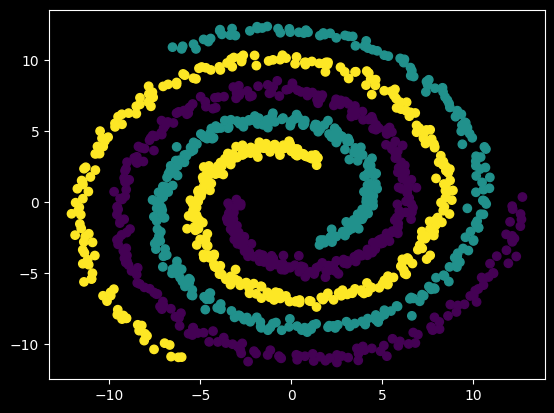

In [7]:
plt.scatter(X[:,0], X[:,1], c=y_true)

In [8]:
threshold = 0.5
rows, cols = np.where(np.triu(W, 1) > threshold)
lines = []
widths = []
colors = []

# Collect lines for efficient plotting
for r, c in zip(rows, cols):
    # Endpoints on X-Z plane
    p1 = X[r]
    p2 = X[c]
    lines.append([p1, p2])
    
    # Thickness = Weight
    w = W[r, c]
    widths.append(w * 2.0) # Scale up slightly for visibility
    
    # Optional: Color edge black if within-cluster, red if cross-cluster (error)
    if y_true[r] == y_true[c]:
        colors.append((1, 2, 1, 0.3)) # Translucent black
    else:
        colors.append((1, 0, 0, 0.6)) # Bright red for "bad" cuts


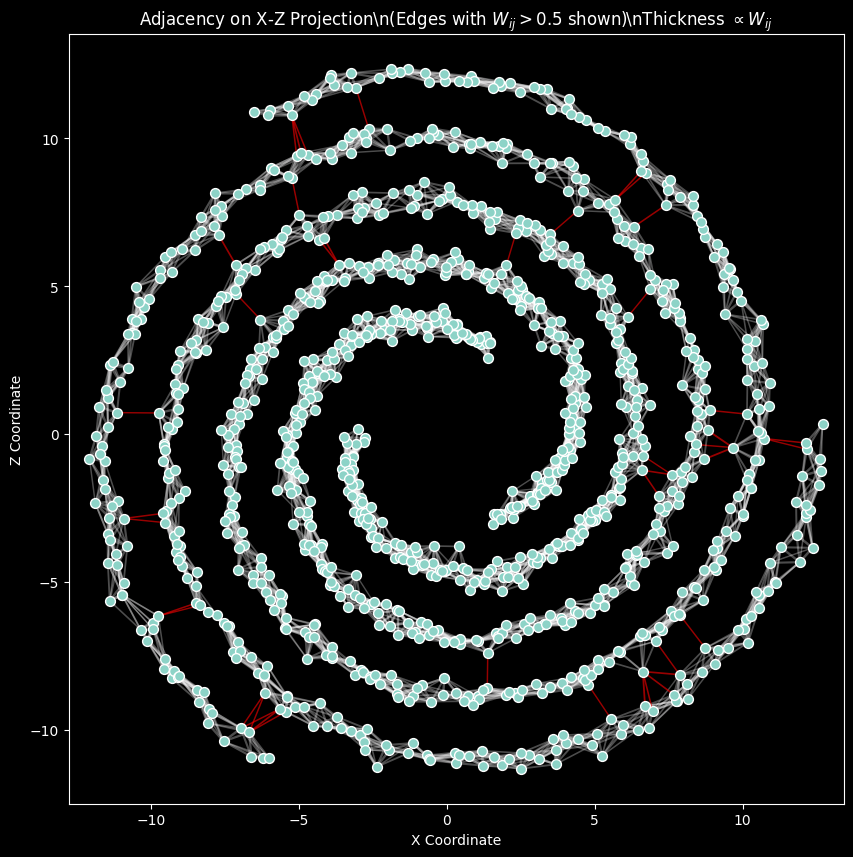

In [9]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
lc = LineCollection(lines, linewidths=widths, colors=colors)
ax.add_collection(lc)

# 5. Scatter Points
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    # c=y_true, cmap="viridis",
    s=50,
    edgecolors="white",
    zorder=10,
)

plt.title(
    rf"Adjacency on X-Z Projection\n(Edges with $W_{{ij}} > {threshold}$ shown)\nThickness $\propto W_{{ij}}$"
)
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.axis("equal")  # Important to keep the circular shape of the helix
# plt.grid(True, alpha=0.3)
plt.show()

In [14]:
def simulation_assignment(P):

    n,k = P.shape

    rng = np.random.rand(n,1)
    cumsum = np.cumsum(P, axis=1)

    z = np.eye(k)[(rng < cumsum).argmax(axis=1)]

    return z

In [15]:
def monte_carlo_expected_cut(P, W, n_samples=400):
    estimate = 0.0
    std = 0.0

    for _ in range(n_samples):
        A = simulation_assignment(P)
        B = 1 - A

        cut = np.diag(B.T @ (W @ A)) / A.sum(axis=0)
        estimate += cut
        std += cut**2

    estimate /= n_samples
    std /= n_samples
        
    return estimate, (std - estimate **2)**0.5

In [16]:
mc_means = []
mc_stds = []
bound_results = []

for tau in temperatures:
    P = softmax(logits / tau, axis=1)

    mc_val, mc_std = monte_carlo_expected_cut(P, W, MC_NUM_SAMPLES)

    # bound_results.append(bound_val)
    mc_val = 0.5 * np.sum(mc_val)
    mc_std = 0.5 * np.sqrt(np.sum(mc_std**2))
    mc_means.append(mc_val)
    mc_stds.append(mc_std)

    print(f"{tau:.4f}     | {mc_val:.4f}   | {mc_std:.4f}       ")  # | {bound_val:.4f}")


0.0001     | 17.2845   | 0.0008       
0.0001     | 17.2846   | 0.0016       
0.0002     | 17.2846   | 0.0023       
0.0002     | 17.2848   | 0.0034       
0.0003     | 17.2850   | 0.0041       
0.0003     | 17.2854   | 0.0054       
0.0004     | 17.2857   | 0.0061       
0.0005     | 17.2864   | 0.0073       
0.0007     | 17.2871   | 0.0079       
0.0008     | 17.2879   | 0.0084       
0.0010     | 17.2886   | 0.0092       
0.0013     | 17.2901   | 0.0102       
0.0017     | 17.2909   | 0.0114       
0.0021     | 17.2924   | 0.0130       
0.0027     | 17.2934   | 0.0138       
0.0034     | 17.2942   | 0.0153       
0.0042     | 17.2954   | 0.0172       
0.0054     | 17.2961   | 0.0194       
0.0068     | 17.2980   | 0.0230       
0.0086     | 17.3002   | 0.0265       
0.0108     | 17.3005   | 0.0302       
0.0137     | 17.3005   | 0.0352       
0.0173     | 17.2992   | 0.0395       
0.0218     | 17.2980   | 0.0438       
0.0276     | 17.2936   | 0.0490       
0.0349     | 17.2906   | 

In [17]:
mc_m = np.array(mc_means)
mc_s = np.array(mc_stds)

In [ ]:
np.save("/buckets/checkpoints/hycut_mc_mean.npy", mc_m)
np.save("/buckets/checkpoints/hycut_mc_std.npy", mc_s)
np.save("/buckets/checkpoints/hycut_mc_tau.npy", temperatures)

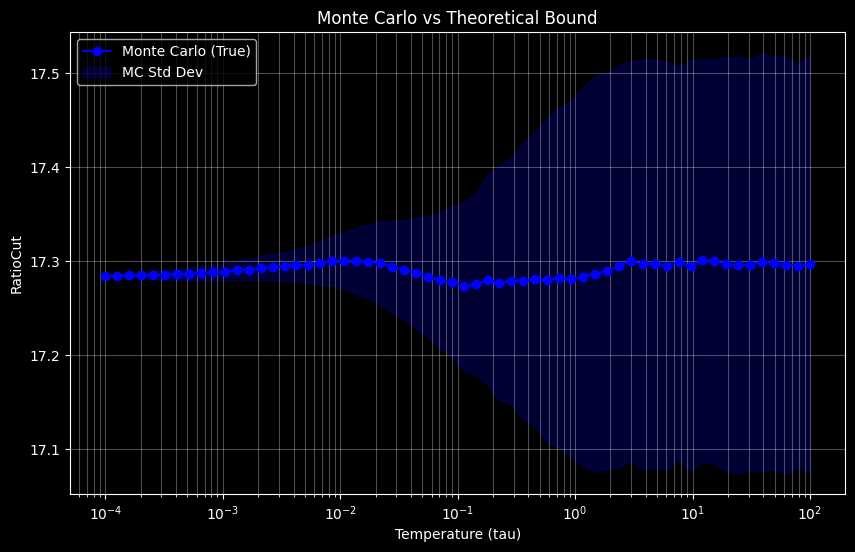

In [18]:
plt.figure(figsize=(10, 6))
    
    # Convert lists to arrays for fill_between

plt.plot(temperatures, mc_m, 'o-', label='Monte Carlo (True)', color='blue')
plt.fill_between(temperatures, mc_m - mc_s, mc_m + mc_s, 
                    color='blue', alpha=0.2, label='MC Std Dev')

# plt.plot(temperatures, bound_vals, 's--', label='Paper Bound (Upper)', color='red')

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel('Temperature (tau)')
plt.ylabel('RatioCut')
plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [33]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(N -2)
b = 1.
c = 2.

estimate = []
prcut_estimate= []
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    omega = P.sum(0)
    alpha_bar = (P**2 /omega[None,1]).sum(0)
    var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    # w_p = -np.diag(P.T@(W@np.log(1e-6+P)))
    # prcut_estimate.append(np.sum(w_p / P.sum(0))/2)
    prcut_estimate.append(w_p / P.sum(0)/2)
    # estimate.append(np.sum(w_p * sp_hyp2f1(a,b,c, P.mean(0)) )/2)
    estimate.append(w_p * sp_hyp2f1(a,b,c, P.mean(0))/2)
    vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

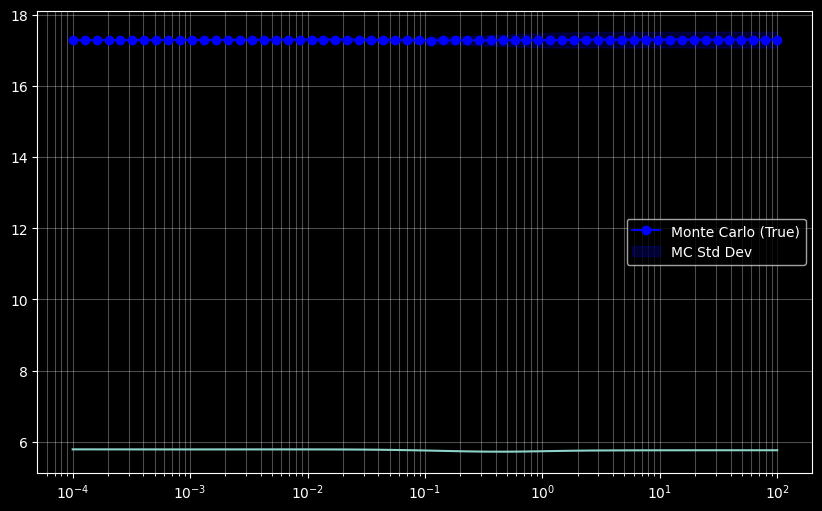

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, mc_m, 'o-', label='Monte Carlo (True)', color='blue')
plt.fill_between(temperatures, mc_m - mc_s, mc_m + mc_s, 
                    color='blue', alpha=0.2, label='MC Std Dev')
plt.plot(temperatures, np.array(estimate)[:,0])
# 
# plt.plot(temperatures, prcut_estimate)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

/tmp/ipykernel_10365/558099168.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


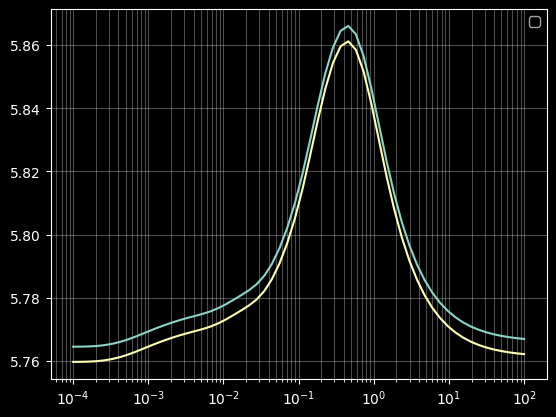

In [37]:
i = 1
plt.plot(temperatures, np.array(estimate)[:,1])
plt.plot(temperatures, np.array(prcut_estimate)[:,1])
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [24]:
temperatures[np.argmin(estimate)], temperatures[np.argmin(prcut_estimate)]

(np.float64(0.7318242219076182), np.float64(0.7318242219076182))

/tmp/ipykernel_9512/1368385446.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


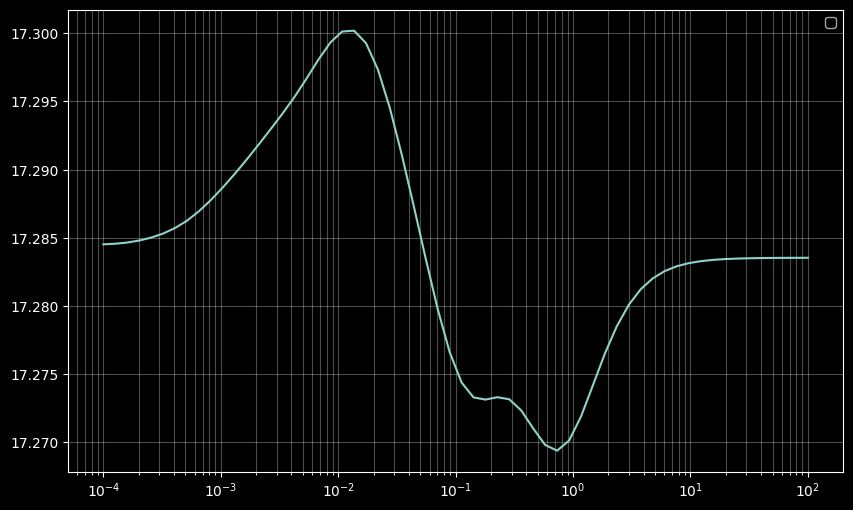

In [72]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, prcut_estimate)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [29]:
def get_safe_zero_aware_variance(P):
    """
    Computes Var_omega(alpha) safely.
    Weights w_i = p_i(1-p_i).
    """
    # 1. Weights: Zero-aware (vanish at 0 and 1)
    W_weights = P * (1.0 - P) # (N, K)
    
    # 2. Sum of weights (Omega)
    Omega = np.sum(W_weights, axis=0) # (K,)
    
    # 3. Handle collapsed weights (Hard assignments)
    # If Omega is tiny, variance is effectively 0.
    valid_mask = Omega > 1e-9
    
    # 4. Weighted Mean: Sum(w * p) / Sum(w)
    # Note: p is P itself.
    weighted_mean = np.zeros_like(Omega)
    num_mean = np.sum(W_weights * P, axis=0)
    weighted_mean[valid_mask] = num_mean[valid_mask] / Omega[valid_mask]
    
    # 5. Weighted Variance: Sum(w * (p - mu)^2) / Sum(w)
    # Broadcast weighted_mean correctly (1, K)
    diff = P - weighted_mean.reshape(1, -1)
    num_var = np.sum(W_weights * (diff**2), axis=0)
    
    weighted_var = np.zeros_like(Omega)
    weighted_var[valid_mask] = num_var[valid_mask] / Omega[valid_mask]
    
    return weighted_var, valid_mask

/tmp/ipykernel_9512/3315488008.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


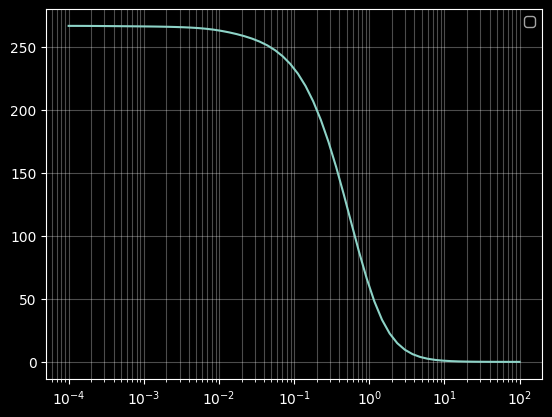

In [30]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [77]:
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    vs.append(get_safe_zero_aware_variance(P)[0].sum())

/tmp/ipykernel_9512/3315488008.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


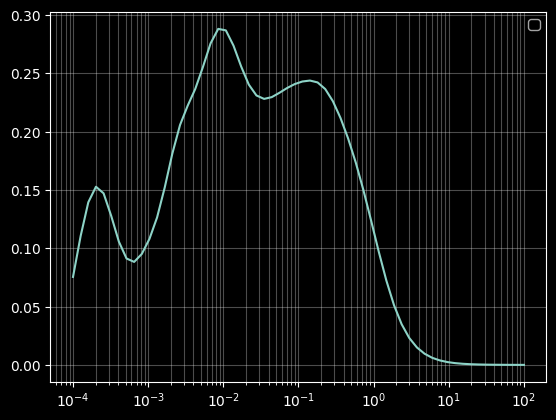

In [78]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

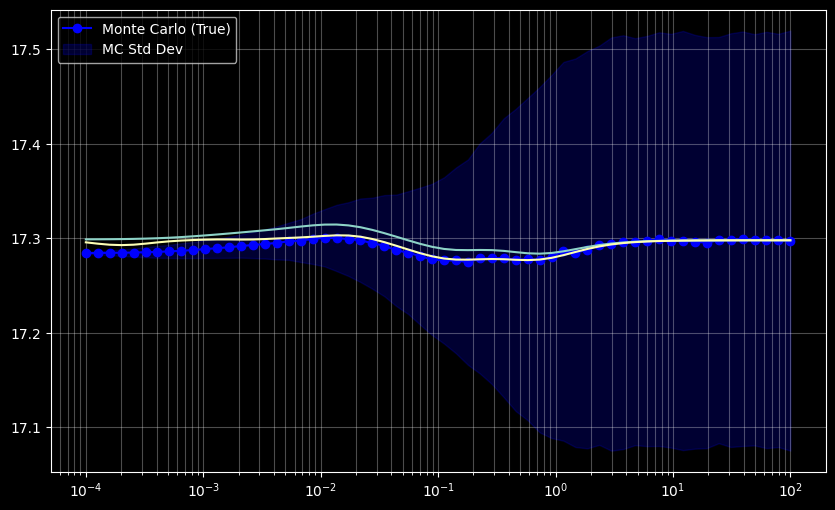

In [79]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, mc_m, 'o-', label='Monte Carlo (True)', color='blue')
plt.fill_between(temperatures, mc_m - mc_s, mc_m + mc_s, 
                    color='blue', alpha=0.2, label='MC Std Dev')
plt.plot(temperatures, estimate)
plt.plot(temperatures, estimate - np.array(vs)/24.0)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [ ]:
# C. Plottin
plt.figure(figsize=(10, 6))
plt.plot(
    temperatures,
    mc_results,
    "o-",
    label="Monte Carlo Estimate (True Expected RatioCut)",
    color="blue",
)
plt.plot(
    temperatures,
    bound_results,
    "s--",
    label="Probabilistic Upper Bound (Theorem 1)",
    color="red",
)

plt.xscale("log")
plt.gca().invert_xaxis()  # High temp (left) to Low temp (right)
plt.xlabel(
    "Temperature (tau) [Log Scale] \n <-- Softer Assignments ... Harder Assignments -->"
)
plt.ylabel("RatioCut Value")
plt.title(
    "Validation of Probabilistic Bounds vs True Expected Cut\n(3 Helices Dataset)"
)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def compute_theoretical_bound(P, W, s_type="ratio"):

    
    n, k = P.shape
    m = n - 2  # As per definition in paper for GPB
    # 1. Compute M_{il}: The 'numerator' part (expected cut edges)
    # This is efficiently calculated via matrix operations.
    # M_il = (W * P_other)_il * P_il ??? No.
    # M_{il} = sum_j W_{ij} P_{il} (1 - P_{jl})
    #        = P_{il} * sum_j W_{ij} (1 - P_{jl})

    # Probability that neighbor j is NOT in cluster l
    P_complement = 1.0 - P

    # Weighted sum of neighbors not in cluster l
    W_dot_P_comp = W @ P_complement

    # M matrix: [N x K]
    M = P * W_dot_P_comp

    # 2. Compute Phi_l(s_i): The 'denominator' bound
    # For RatioCut, s_i = 1 for all i. q = 1. beta = 1.
    # The bound depends on the Mean Assignment alpha_bar for cluster l.

    bound_val = 0.0

    if s_type == "ratio":
        # Calculate mean assignment prob for each cluster: alpha_bar_l
        # The paper defines alpha_bar over the 'other' nodes, but for large N,
        # 1/m * Sum_{all} P_il is the standard approximation.
        alpha_bar = np.mean(P, axis=0)  # [K]

        for l in range(K):
            # Compute H function for this cluster's occupancy
            # For RatioCut: q=1, beta=1
            H_val = horner_hypergeometric_ratio_cut(
                m, alpha_bar[l], q=1, beta=1
            )

            # Sum over all nodes i
            # For RatioCut, Phi is constant for all i in cluster l (since s_i=1)
            # contribution = Sum_i M_{il} * H_val

            cut_mass_l = np.sum(M[:, l])
            bound_val += cut_mass_l * H_val

    return 0.5 * bound_val  # GraphCut is 1/2 sum VolCut

In [ ]:
def horner_hypergeometric_ratio_cut(m, alpha_bar, q=1, beta=1):
    """
    Computes the Hypergeometric envelope H_beta(q; alpha, m) for RatioCut.
    Using Eq (11) and Algorithm 1 logic (Horner's rule/Finite Sum).

    For RatioCut: q=1, beta=1.
    c = q/beta + 1 = 2.

    We need to compute: (1/q) * 2F1(-m, 1; c; alpha_bar)
    Since -m is a negative integer, the series truncates at term m.
    """
    # 2F1(-m, 1; c; z) = sum_{k=0}^{m} [(-m)_k * (1)_k] / [(c)_k * k!] * z^k
    #                  = sum_{k=0}^{m} [(-m)_k] / [(c)_k] * z^k

    c = (q / beta) + 1
    z = alpha_bar

    # We evaluate the polynomial using a loop for stability (Algorithm 1)
    # Series: 1 + T1 + T2 + ...
    # T_k = T_{k-1} * (-m + k - 1) * z / (c + k - 1)

    current_term = 1.0
    total_sum = 1.0

    # Note: For very large m, direct computation can be numerically sensitive.
    # The paper suggests early exit or log-domain, but for N=1200
    # and standard float64, this summation usually holds up well enough for demo.

    for k in range(1, m + 1):
        # Update factor derived from ratio of coefficients
        factor = (-m + k - 1) * z / (c + k - 1)
        current_term *= factor
        total_sum += current_term

        # Optimization: Early exit if term vanishes (precision floor)
        if abs(current_term) < 1e-15:
            break

    return (1.0 / q) * total_sum




def run_simulation():
    # A. Setup Data
    

    for tau in temperatures:
        # 1. Softmax with temperature
        P = softmax(logits / tau, axis=1)

        # 2. Monte Carlo Estimate (The "True" Expected Cut)
        mc_val = monte_carlo_expected_cut(P, W, n_samples=30)

        # 3. Theoretical Upper Bound
        bound_val = compute_theoretical_bound(P, W, s_type="ratio")

        mc_results.append(mc_val)
        bound_results.append(bound_val)

        print(f"{tau:.4f}     | {mc_val:.4f}          | {bound_val:.4f}")

    # C. Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(
        temperatures,
        mc_results,
        "o-",
        label="Monte Carlo Estimate (True Expected RatioCut)",
        color="blue",
    )
    plt.plot(
        temperatures,
        bound_results,
        "s--",
        label="Probabilistic Upper Bound (Theorem 1)",
        color="red",
    )

    plt.xscale("log")
    plt.gca().invert_xaxis()  # High temp (left) to Low temp (right)
    plt.xlabel(
        "Temperature (tau) [Log Scale] \n <-- Softer Assignments ... Harder Assignments -->"
    )
    plt.ylabel("RatioCut Value")
    plt.title(
        "Validation of Probabilistic Bounds vs True Expected Cut\n(3 Helices Dataset)"
    )
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)

    plt.tight_layout()
    plt.show()


Generating 3 Helices (N=1200)...
Computing Affinity Matrix (RBF)...
Temp       | MC (True)       | Bound (Ours)   
---------------------------------------------
10.0000     | 0.0000          | -1601064592320792579070597133588087221287233919164287190688113014957859673203058549214815591897718636642608052978182674242941461383348224.0000
7.8476     | 0.0000          | 221218349202363235048523342188563944201723652091920998363657418423574725917753215827046772934859446596336214513940900004739601636786176.0000
6.1585     | 0.0000          | -536788184523569464012291913551381604409695480961504950661752674289011506527994381446670239846749204718061149942521908097083722073899008.0000
4.8329     | 0.0000          | -1976789401995814485753204308151931707485213849165555512277294350070876616798673265359564308822454173847395595775482753906682281125216256.0000
3.7927     | 0.0000          | 379370949712209805598713547374287307116914459174095116344559421833225060937949289399935673968733573654372588804598

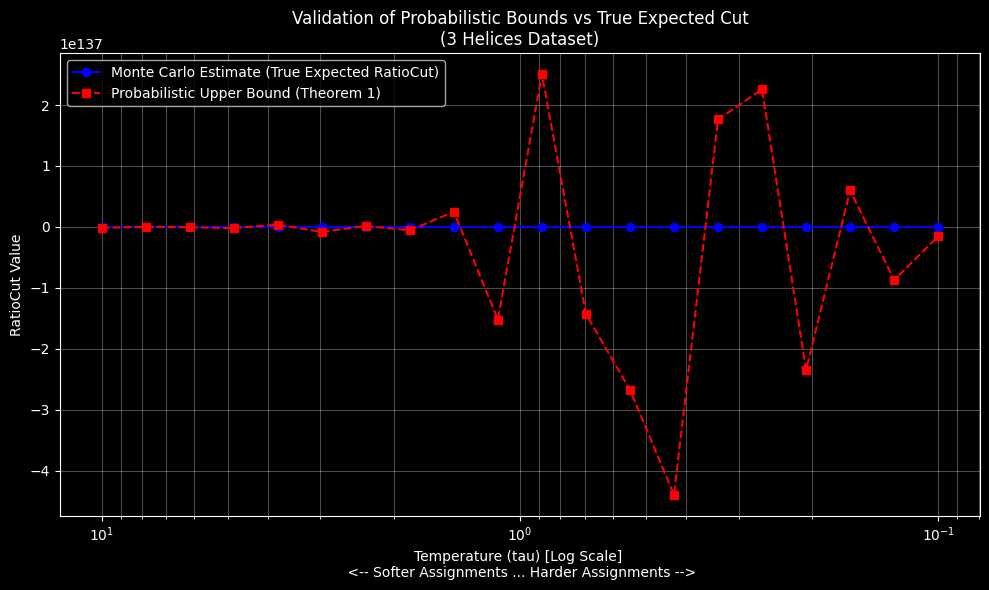

In [18]:
run_simulation()

In [ ]:

print(f"{'Temp':<10} | {'MC (True)':<15} | {'Bound (Ours)':<15}")
print("-" * 45)